In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline
plt.style.use('seaborn')

In [2]:
df_raw = pd.read_csv('data/tx_ev_registrations_public.csv')
df_raw = df_raw[(df_raw.Technology == 'BEV')]
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1054127 entries, 0 to 1133466
Data columns (total 12 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   Vehicle ID                    1054127 non-null  object 
 1   ZIP Code                      1054127 non-null  object 
 2   Registration Valid Date       1054127 non-null  object 
 3   VIN Prefix                    1054127 non-null  object 
 4   DMV_ID                        1054127 non-null  int64  
 5   DMV ID Complete               1054127 non-null  object 
 6   DMV Snapshot                  1054127 non-null  object 
 7   Registration Expiration Date  0 non-null        float64
 8   State Abbreviation            1054127 non-null  object 
 9   Geography                     1054127 non-null  object 
 10  Vehicle Name                  1054127 non-null  object 
 11  Technology                    1054127 non-null  object 
dtypes: float64(1), int64(1), obj

In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

In [4]:
# years = pd.Dataframe(df_raw['Registration Valid Date' ])

Year
2019-11-01        131.0
2019-11-02        133.0
2019-11-03        136.0
2019-11-04        149.0
2019-11-05        162.0
                ...    
2022-06-28    1052887.0
2022-06-29    1053129.0
2022-06-30    1053332.0
2022-07-01    1054122.0
2022-08-01    1054127.0
Name: Registered Vehicles, Length: 962, dtype: float64

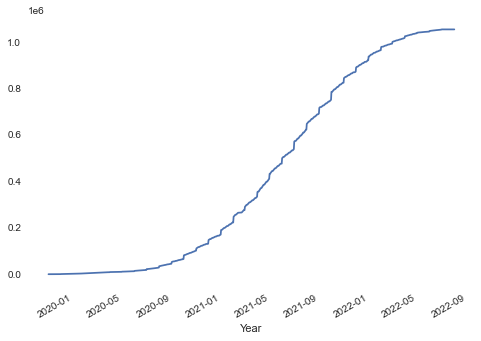

In [5]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df = df['Registered Vehicles'].cumsum()
sns.set_style(style='white')
df.plot()
df


In [6]:
# result = seasonal_decompose(df, model='multiplicative')
# fig = result.plot()

In [7]:
# df['Registered Vehicles'].mean()

## **RESAMPLING

In [8]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [9]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

In [10]:
# # #Frontfill 
# df = df.resample('M').ffill()
# df.plot()

## First Model (before train/test split)

In [11]:
auto_model = pm.auto_arima(df, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=28265.140, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=18169.962, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=18196.164, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=18160.201, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=27388.509, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=18149.734, Time=0.49 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=27351.650, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.68 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=18144.108, Time=0.57 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=27345.486, Time=0.21 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=1.05 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=18142.0

## Testing 

In [12]:
adtest = adfuller(df)
display(adtest)

(1.8064788951436936,
 0.9983617807167398,
 8,
 953,
 {'1%': -3.4372303791313144,
  '5%': -2.864577551835195,
  '10%': -2.568387363624452},
 17631.227053219984)

## Modeling

In [13]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2017-06-30':'2021-12-31']
test = df['2022-01-31':'2022-08-01']
combined = df
test

Year
2022-01-31     964663.0
2022-02-01     978135.0
2022-02-02     979132.0
2022-02-03     979538.0
2022-02-04     979795.0
                ...    
2022-06-28    1052887.0
2022-06-29    1053129.0
2022-06-30    1053332.0
2022-07-01    1054122.0
2022-08-01    1054127.0
Name: Registered Vehicles, Length: 153, dtype: float64

In [14]:
# naive = train.shift(1)
# np.sqrt(mean_squared_error(train[1:], naive.dropna()))

In [15]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22376.503, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14827.181, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=14846.575, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=14819.679, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=21670.839, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=14810.826, Time=0.36 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=21642.266, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=14806.439, Time=0.44 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=21637.999, Time=0.16 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=14804.9

### The best model is :  ARIMA (3,0,0) (0,0,0) [0]
### (1, 0, 6)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0031      0.000   3816.765      0.000       1.003       1.004
ma.L1          0.0319      0.070      0.455      0.649      -0.106       0.169
ma.L2          0.0092      0.076      0.121      0.903      -0.140       0.158
ma.L3          0.0117      0.075      0.157      0.876      -0.135       0.158
ma.L4          0.0080      0.076      0.105      0.916      -0.141       0.156
ma.L5         -0.0006      0.083     -0.007      0.994      -0.163       0.162
ma.L6          0.0291      0.067      0.437      0.662      -0.101       0.160
sigma2       9.41e+06   8.13e-09   1.16e+15      0.000    9.41e+06    9.41e+06


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


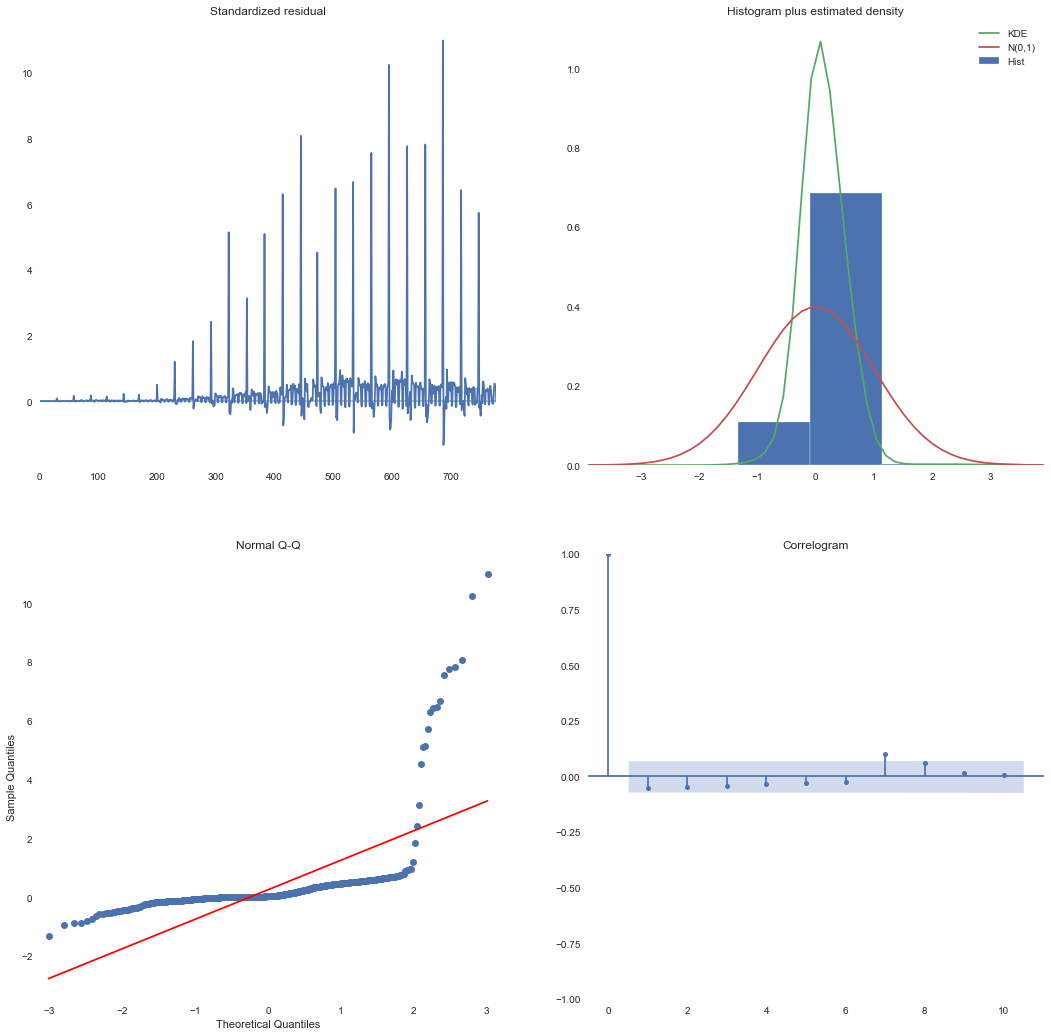

In [16]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(1,0,6), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()



In [17]:
pred = output.get_prediction(start=pd.to_datetime('2021-12-31'), end=pd.to_datetime('2022-07-31'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [ ]:

sns.set_style(style='white')
rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in  thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Texas Performance Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [ ]:
# Beginning our forecasting for next 3 years (36 months)
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(combined, 
                                        order=(4,0,3), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int(alpha=.3)
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

In [ ]:
future_prediction['prediction'].sum()

In [ ]:
sns.set_style(style='white')
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Actual')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'], color = 'lightblue',
                label='Confidence Interval')


ax.set_xlabel('Year',fontsize=20)
plt.xticks(fontsize=20)
ax.set_ylabel('Number of EVs',fontsize=20)
plt.yticks(fontsize=20)

# scale_y = 1e5
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Texas EV Forecast',fontsize=30)
plt.legend(fontsize = 15)
plt.show()